[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/DIN.ipynb)

> This notebook runs DIN on MovieLens1M dataset. We'll use YouTubeDNN for generating candidates and DIN for ranking these candidates.

> Only movies with ratings larger than 3 are treated as 'positive' samples for each user. Every last 10 'positive' movies of each user are held out for testing.

## Table of Contents:
* [Prepare data for retrieval](#section-0)
* [Train retrieve model and export embeddings](#section-1)
* [Use Faiss to generate candidates](#section-2)
* [Train rank model and predict](#section-3)

**Download dataset and install packages**

In [1]:
! git clone https://github.com/Wp-Zhang/HandyRec.git
! pip install faiss-cpu

Cloning into 'HandyRec'...
remote: Enumerating objects: 1704, done.
remote: Counting objects: 100% (1704/1704), done.
remote: Compressing objects: 100% (1269/1269), done.
remote: Total 1704 (delta 682), reused 1309 (delta 383), pack-reused 0
Receiving objects: 100% (1704/1704), 20.92 MiB | 24.51 MiB/s, done.
Resolving deltas: 100% (682/682), done.
     |████████████████████████████████| 8.6 MB 13.2 MB/s 


In [2]:
! wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
! unzip -o ml-1m.zip

--2022-04-15 22:54:20--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  27.1MB/s    in 0.2s    

2022-04-15 22:54:21 (27.1 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


**Import relative packages**

In [3]:
import sys
sys.path.append('./HandyRec/')

In [4]:
from handyrec.data.movielens import MovielensDataHelper
from handyrec.data.utils import gen_sequence
from handyrec.data import PointWiseDataset

from handyrec.layers.utils import sampledsoftmaxloss
from handyrec.models.retrieval import YouTubeMatchDNN
from handyrec.models.ranking import DIN
from handyrec.features import DenseFeature, SparseFeature, SparseSeqFeature, FeatureGroup, EmbdFeatureGroup, FeaturePool
from handyrec.data.metrics import map_at_k, recall_at_k
from handyrec.models.utils import search_embedding

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import gc

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
RETRIEVAL_EMBEDDING_DIM = 64
RANK_EMBEDDING_DIM = 64
SEQ_LEN = 40
BATCH_SIZE = 2**12
NEPOCH = 50

TEST_NUM = 10
VALID_RATIO = 0.1
NEG_NUM = 10
CANDIDATE_NUM = 100

**Load MovieLens1M data**

In [7]:
retrieve_dh = MovielensDataHelper('./ml-1m/')
data = retrieve_dh.get_clean_data(sparse_features=['gender','occupation','zip','age','year'])
data['inter']['hist_movie'] = gen_sequence(data['inter'], 'user_id', 'movie_id', SEQ_LEN)

Generate movie_id sequence: 100%|██████████| 6040/6040 [00:04<00:00, 1247.11it/s]


# 0. Prepare data for retrieval<a name="section-0"></a>

In [8]:
user_features = ['user_id', 'gender', 'occupation']
item_features = ['movie_id','genres']
inter_features = ['hist_movie']

In [9]:
retrieval_dataset = PointWiseDataset(
    "RetrievalDataset",
    task="retrieval",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    threshold=4,
)

retrieval_dataset.train_test_split(TEST_NUM)
retrieval_dataset.train_valid_split(VALID_RATIO)
retrieval_dataset.gen_dataset(user_features, item_features, inter_features, shuffle=False)

Save inter features: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


In [10]:
train_data, valid_data, test_data, test_label = retrieval_dataset.load_dataset(
    user_features, item_features, inter_features, BATCH_SIZE
)

Load inter features: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


In [11]:
feature_dim = retrieval_dataset.get_feature_dim(user_features, item_features, [])

# 1. Train retrieve model and export embeddings <a name="section-1"></a>

In [12]:
feat_pool1 = FeaturePool()

In [13]:
all_item_model_input = {f:np.array(data['item'][f].tolist()) for f in item_features}

retrieve_item_features = [SparseFeature('movie_id', feature_dim['movie_id'], RETRIEVAL_EMBEDDING_DIM)] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, RETRIEVAL_EMBEDDING_DIM), 'genres',6)]
item_feature_group = EmbdFeatureGroup(
    name='item', 
    id_name='movie_id', 
    features=retrieve_item_features, 
    feature_pool=feat_pool1, 
    value_dict=all_item_model_input,
    embd_dim=RETRIEVAL_EMBEDDING_DIM
)

In [14]:
retrieve_user_features = [SparseFeature(x, feature_dim[x], RETRIEVAL_EMBEDDING_DIM) for x in user_features] +\
                [SparseSeqFeature(SparseFeature('movie_id', feature_dim['movie_id'], RETRIEVAL_EMBEDDING_DIM), 'hist_movie', SEQ_LEN)]
user_feature_group = FeatureGroup('user', retrieve_user_features, feat_pool1)

In [15]:
retrieve_model = YouTubeMatchDNN(
    user_feature_group, item_feature_group,
    dnn_hidden_units=(512,256,RETRIEVAL_EMBEDDING_DIM), 
    dnn_dropout=0.1,
    dnn_bn=True,
    num_sampled=CANDIDATE_NUM
)

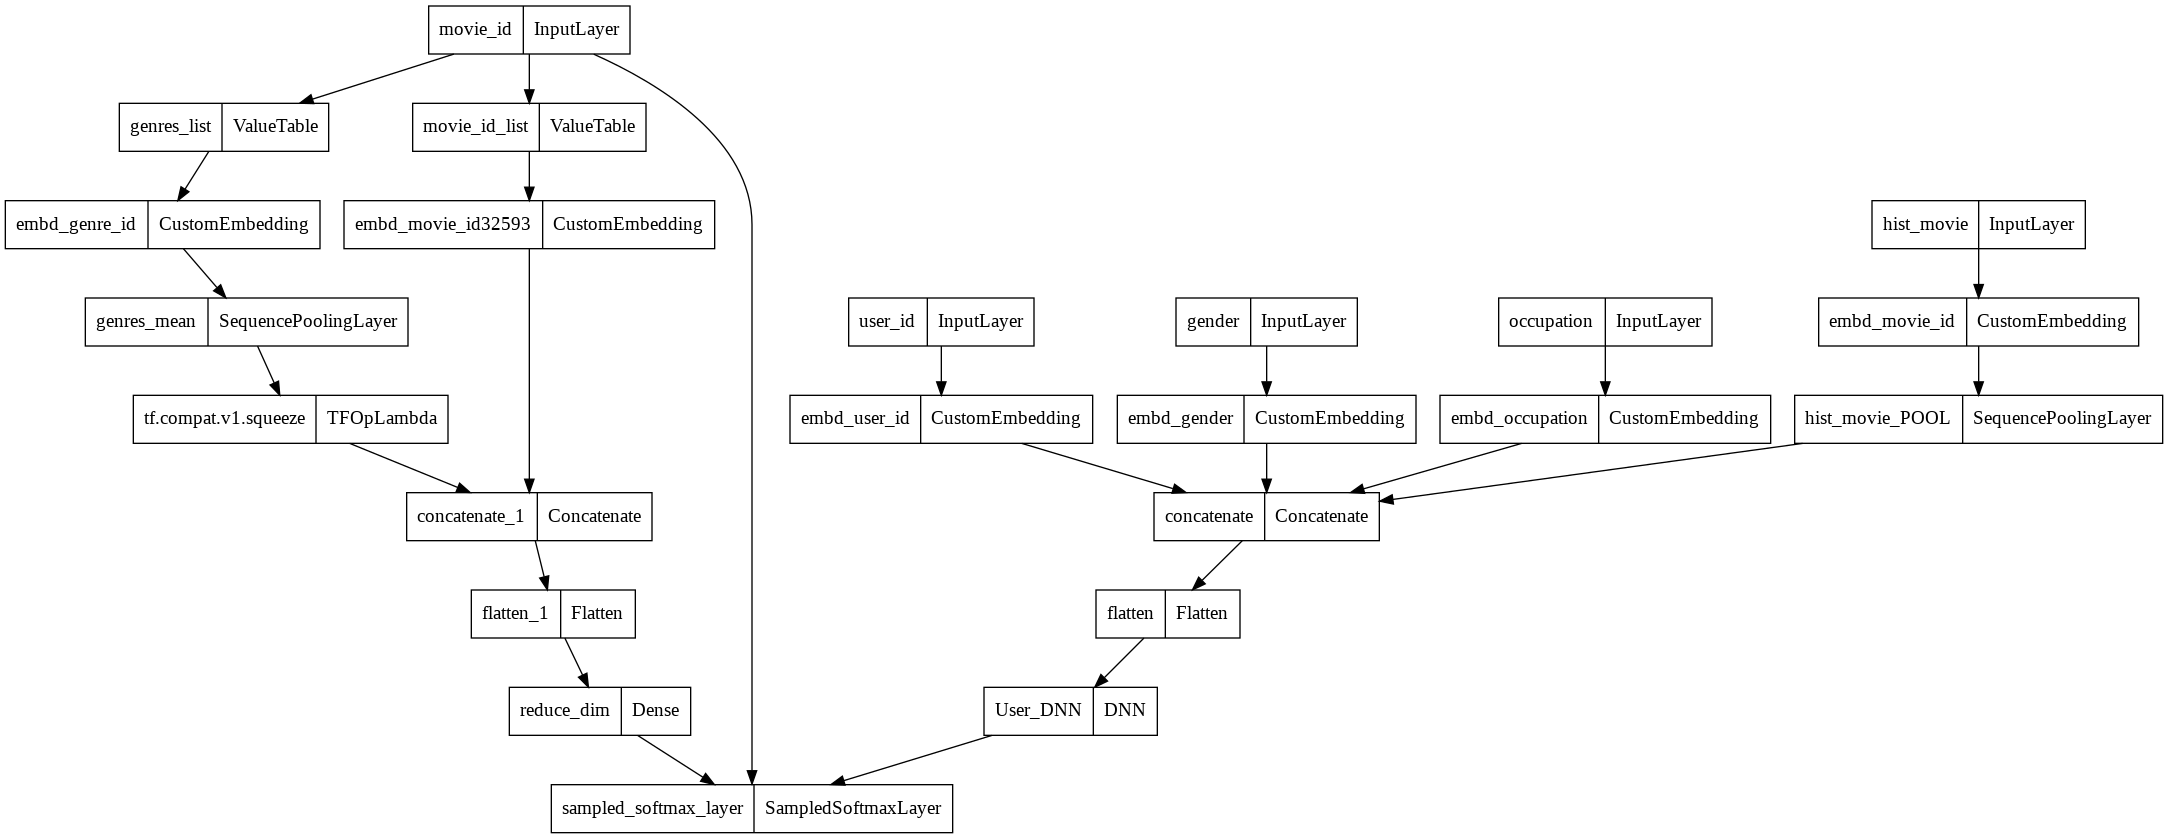

In [16]:
plot_model(retrieve_model)

In [17]:
retrieve_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=sampledsoftmaxloss)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./retrieve_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = retrieve_model.fit(
    x=train_data,
    validation_data=valid_data,
    epochs=NEPOCH,
    callbacks=[early_stop, checkpoint],
)

Epoch 1/50
114/114 [==============================] - 10s 37ms/step - loss: 3.9437 - val_loss: 3.9070
Epoch 2/50
114/114 [==============================] - 4s 32ms/step - loss: 3.8213 - val_loss: 3.8941
Epoch 3/50
114/114 [==============================] - 4s 34ms/step - loss: 3.0544 - val_loss: 3.3654
Epoch 4/50
114/114 [==============================] - 4s 32ms/step - loss: 2.5058 - val_loss: 2.9170
Epoch 5/50
114/114 [==============================] - 4s 33ms/step - loss: 2.3097 - val_loss: 2.5709
Epoch 6/50
114/114 [==============================] - 4s 34ms/step - loss: 2.1591 - val_loss: 2.3047
Epoch 7/50
114/114 [==============================] - 4s 33ms/step - loss: 2.1436 - val_loss: 2.1971
Epoch 8/50
114/114 [==============================] - 4s 34ms/step - loss: 2.0509 - val_loss: 2.0743
Epoch 9/50
114/114 [==============================] - 4s 34ms/step - loss: 2.0212 - val_loss: 2.0176
Epoch 10/50
114/114 [==============================] - 4s 32ms/step - loss: 1.9405 - val_l

In [18]:
retrieve_model.load_weights('./retrieve_checkpoint/')

In [19]:
user_embedding_model = Model(inputs=retrieve_model.user_input, outputs=retrieve_model.user_embedding)
item_embedding_model = Model(inputs=retrieve_model.item_input, outputs=retrieve_model.item_embedding)

user_embs = user_embedding_model.predict(test_data, batch_size=2 ** 15)
item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 15)

print(user_embs.shape)
print(item_embs.shape)

(5923, 64)
(3883, 64)


# 2. Use Faiss to generate candidates <a name="section-2"></a>

## Test retrieve model

In [20]:
candidates = search_embedding(
    RETRIEVAL_EMBEDDING_DIM, 
    item_embs, 
    user_embs,
    data['item']['movie_id'].values,
    CANDIDATE_NUM)

In [21]:
map_at_k(test_label, candidates, k=10)

0.011312806680441325

In [22]:
recall_at_k(test_label, candidates, k=10)

0.030761438460239748

In [23]:
recall_at_k(test_label, candidates, k=100)

0.13785243964207328

## Prepare data for ranking

In [24]:
test_user_embs = user_embedding_model.predict(test_data, batch_size=2 ** 15)
test_candidates = search_embedding(
    RETRIEVAL_EMBEDDING_DIM, 
    item_embs, 
    test_user_embs,
    data['item']['movie_id'].values,
    CANDIDATE_NUM)

test_candidates = {
    test_data['user_id'][i] : test_candidates[i]
    for i in range(test_candidates.shape[0])
}

In [25]:
del user_embs, item_embs, train_data, test_user_embs
gc.collect()

8879

In [26]:
user_features = ['user_id', 'gender', 'occupation', 'zip', 'age']
item_features = ['movie_id', 'year', 'genres']
inter_features = ['hist_movie']

In [27]:
ranking_dataset = PointWiseDataset(
    "RankingDataset",
    task="ranking",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    threshold=4,
)

ranking_dataset.train_test_split(TEST_NUM)
ranking_dataset.negative_sampling(NEG_NUM)
ranking_dataset.train_valid_split(VALID_RATIO)
ranking_dataset.gen_dataset(user_features, item_features, inter_features, test_candidates)

Save inter features: 100%|██████████| 2/2 [00:37<00:00, 18.62s/it]


In [28]:
train_data, valid_data, test_data, test_label = ranking_dataset.load_dataset(
    user_features, item_features, inter_features, BATCH_SIZE*2
)

Load inter features: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


In [29]:
feature_dim = ranking_dataset.get_feature_dim(user_features, item_features, [])

# 3. Train rank model and predict <a name="section-3"></a>

In [30]:
feat_pool2 = FeaturePool()

In [31]:
rank_item_seq_features = [SparseSeqFeature(SparseFeature('movie_id', feature_dim['movie_id'], RANK_EMBEDDING_DIM), 'hist_movie', SEQ_LEN)]
item_seq_feat_group = FeatureGroup('item_seq', rank_item_seq_features, feat_pool2)

In [32]:
rank_other_feats = [SparseFeature(x, feature_dim[x], RANK_EMBEDDING_DIM) for x in user_features + item_features[:-1]] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, RANK_EMBEDDING_DIM), 'genres',6)]
other_feature_group = FeatureGroup('user', rank_other_feats, feat_pool2)

In [33]:
rank_model = DIN(
    item_seq_feat_group, other_feature_group, 
    dnn_hidden_units=(256,128,1), dnn_activation='dice', dnn_dropout=0.2, l2_dnn=0.2, dnn_bn=True,
    lau_dnn_hidden_units=(36,1), lau_dnn_activation='dice', lau_dnn_dropout=0., lau_l2_dnn=0.2, lau_dnn_bn=False,
)

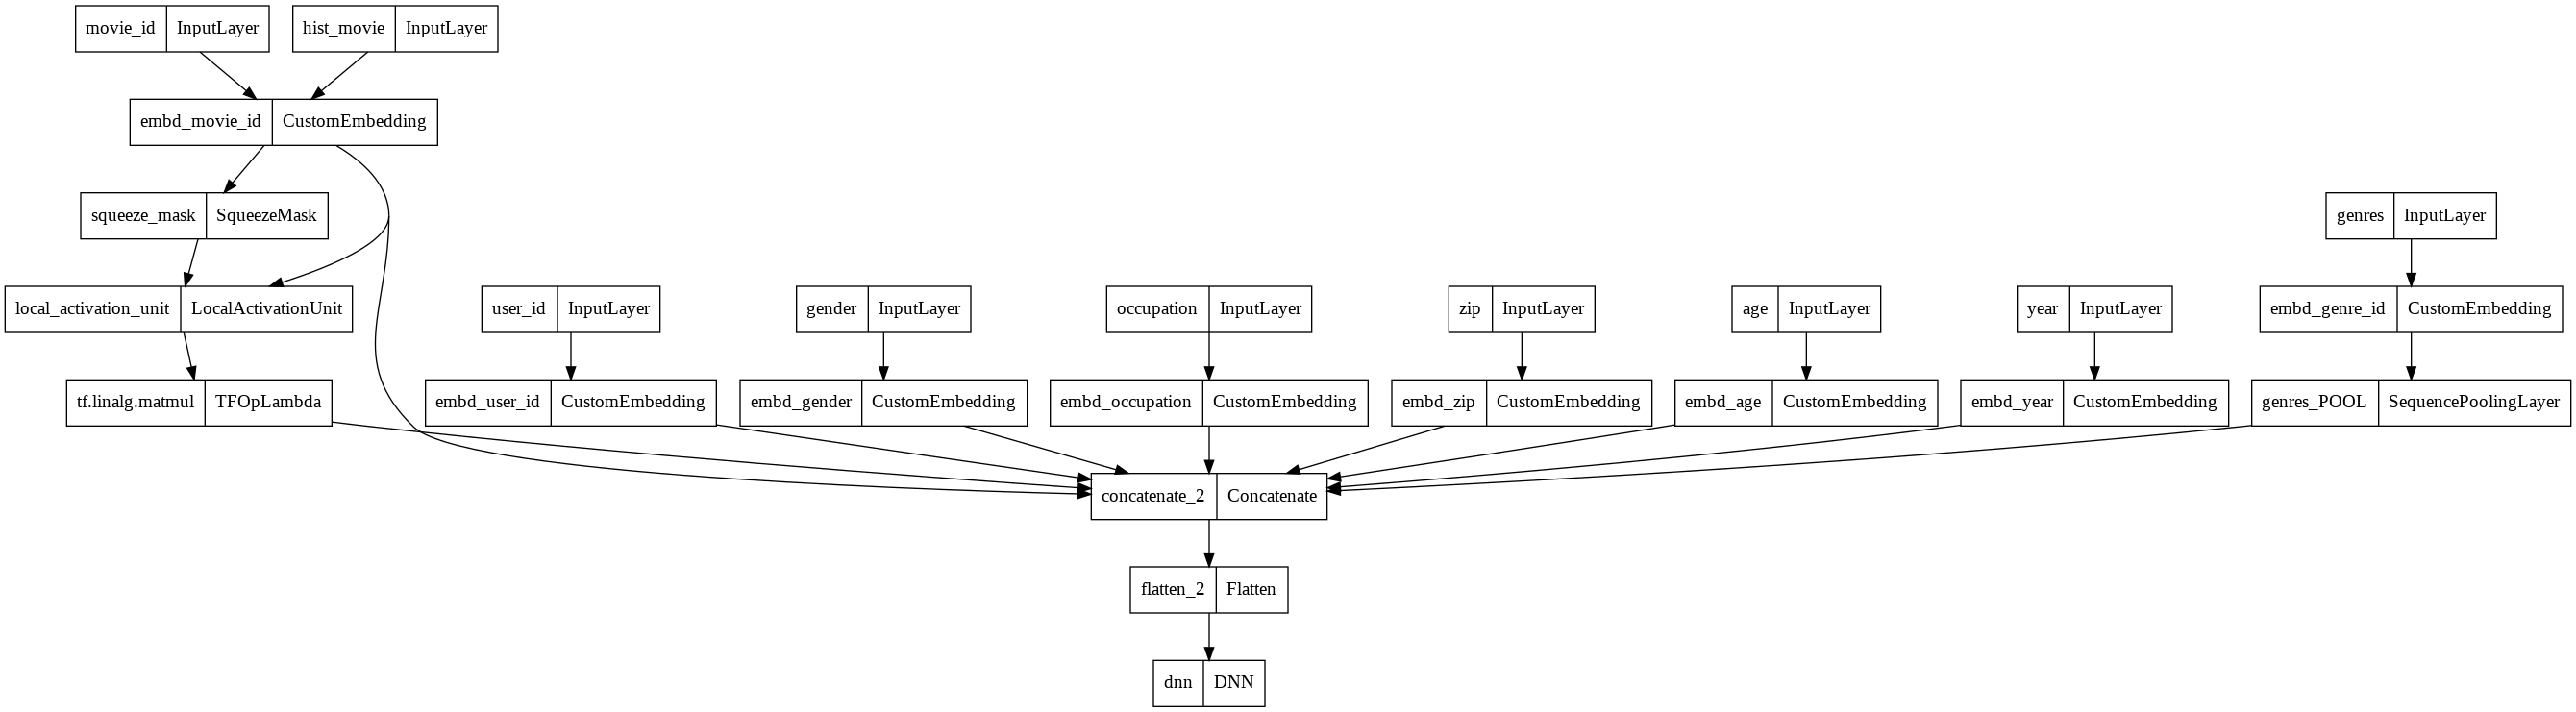

In [34]:
plot_model(rank_model)

In [35]:
rank_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=binary_crossentropy)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./rank_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = rank_model.fit(
    x=train_data, 
    validation_data=valid_data,
    epochs=NEPOCH,
    callbacks=[early_stop,checkpoint]
)

Epoch 1/50
623/623 [==============================] - 170s 266ms/step - loss: 199.0790 - val_loss: 131.5712
Epoch 2/50
623/623 [==============================] - 169s 270ms/step - loss: 89.8292 - val_loss: 56.5621
Epoch 3/50
623/623 [==============================] - 169s 270ms/step - loss: 38.0922 - val_loss: 23.2930
Epoch 4/50
623/623 [==============================] - 170s 272ms/step - loss: 15.8574 - val_loss: 9.6721
Epoch 5/50
623/623 [==============================] - 170s 273ms/step - loss: 6.8854 - val_loss: 4.0774
Epoch 6/50
623/623 [==============================] - 170s 272ms/step - loss: 3.2631 - val_loss: 2.6064
Epoch 7/50
623/623 [==============================] - 171s 273ms/step - loss: 2.0878 - val_loss: 1.3921
Epoch 8/50
623/623 [==============================] - 169s 270ms/step - loss: 1.3585 - val_loss: 0.7915
Epoch 9/50
623/623 [==============================] - 169s 270ms/step - loss: 0.8987 - val_loss: 0.6171
Epoch 10/50
623/623 [==============================] - 

In [36]:
rank_model.load_weights('./rank_checkpoint/')

In [37]:
del train_data
gc.collect()

9320

In [38]:
pred = rank_model.predict(test_data, batch_size=BATCH_SIZE)

In [39]:
pred_df = pd.DataFrame(columns=['user_id','movie_id','pred'])
pred_df['user_id'] = test_data['user_id']
pred_df['movie_id'] = test_data['movie_id']
pred_df['pred'] = pred

pred_df = pred_df.sort_values(by=['user_id','pred'], ascending=False).reset_index(drop=True)
pred_df = pred_df.groupby('user_id')['movie_id'].apply(list).reset_index()

In [40]:
test_label_df = pd.DataFrame(columns=['user_id','label'])
test_label_df['user_id'] = pd.Series(test_data['user_id']).drop_duplicates()
test_label_df['label'] = test_label.tolist()

In [41]:
test_label_df = pd.merge(test_label_df, pred_df, on=['user_id'], how='left')

In [42]:
map_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.01098307244559144

In [43]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.03133547188924531

In [44]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=100)

0.13785243964207328